## Part 3: Tackling the Eigen cation through exploratory simulations and active learning

In the third part of the tutorial, we will turn our attention to the **Eigen cation**.

Clearly, our current Zundel model already has some degree of knowledge about protonated water clusters: for instance, it knows how an OH bond behaves, it can describe hydrogen bonding and, to some extent, the behavior of proton defects.
However, one might expect that using such a model to run a simulation of a related, but distinct species such as the Eigen cation will not be an overwhelming success straight away. Still, we can rely on active learning to quickly target disagreement outliers and retrain our model iteratively using QbC to gain knowledge across new, unexplored potential energy landscapes.
The only difference now is that our candidate pool is **unlabeled** and we will need to provide the labels (*i.e.*, energies and forces) on the fly during QbC.

In [1]:
import os, logging
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt

from ase import Atoms
from ase.visualize import view
from ase.io import read, write # read and write structures
from ase.calculators.calculator import Calculator, all_changes, all_properties

# import functions to run this tutorial
from myfunctions import train_mace                # train MACE model
from myfunctions import eval_mace                 # evaluate MACE model
from myfunctions import extxyz2energy             # extract energy from extxyz file
from myfunctions import extxyz2array              # extract forces from extxyz file
from myfunctions import run_qbc                   # run Query by Committee
from myfunctions import run_single_aims_structure # call FHI-aims

plt.style.use('notebook.mplstyle')                # use notebook style for plots

n_committee = 4                                   # number of committee members

# set random seed for reproducibility
np.random.seed(0) 
seeds = np.random.randint(0, 2**32 - 1, size=n_committee, dtype=np.uint32)

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


## Part III-a: Eigen inference

First, we will use the existing model trained only on Zundel structures to perform an **exploratory simulation** of the Eigen. Compared to the previous Zundel inference, how does the force disagreement behave during this trajectory?

In [9]:
view(read('../initial-datasets/eigen/eigen.xyz', index=0), viewer='x3d')

## TODO:

Go to the folder `ipi-examples/eigen-inference` and run an NVT MD simulation of the Eigen cation using the existing model.

Link the correct MACE files in the `run.sh` file.

After having ran the exploratory simulation, collect the individual committee member forces, 
calculate the disagreement along the trajectory and represent it with a `numpy.array()` called `disagreement` with the length of the trajectory.

  0%|          | 0/4 [00:00<?, ?it/s]

The average force disagreement over the trajectory is 0.164314 eV/Ang.


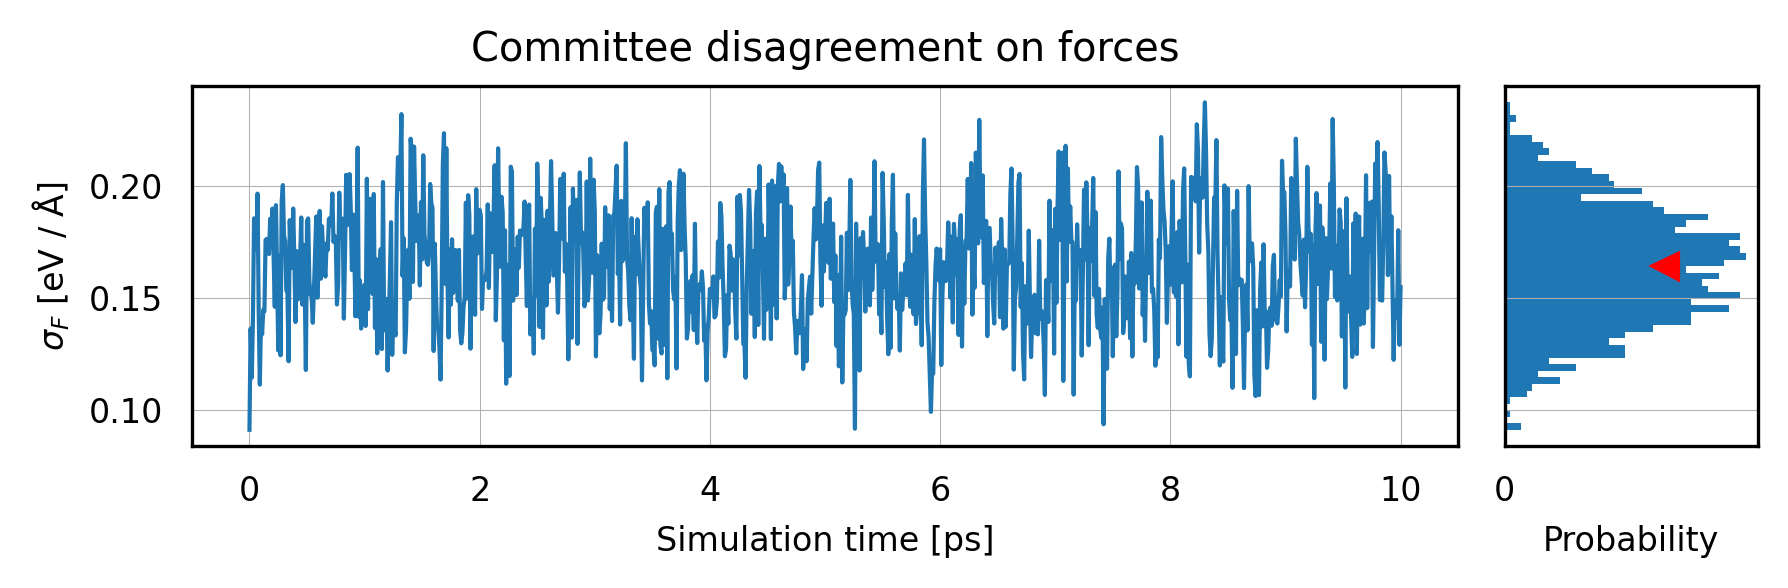

In [14]:
# read the results
forces = np.array([extxyz2array(f'../ipi-examples/eigen-inference/ipi.mace_force_{n:d}.extxyz', 
                                keyword='forces_component_raw') 
                   for n in tqdm(range(n_committee))])

dforces = forces - forces.mean(axis=0)[None, ...]
disagreement_atomic = np.sqrt( ( (dforces**2).sum(axis=3) ).mean(axis=0) )
disagreement = disagreement_atomic.mean(axis=1)

# plot the disagreement
dt = 0.5e-3 # ps
stride = 20 # steps
time = np.arange(0, len(disagreement)) * dt * stride

print(f'The average force disagreement over the trajectory is {disagreement.mean():03f} eV/Ang.')

fig, ax = plt.subplots(ncols=2, nrows=1, sharey=True, gridspec_kw=dict(width_ratios=[1, 0.2]))
ax[0].plot(time, disagreement)
ax[0].set_ylabel(r'$\sigma_F$ [eV / $\mathrm{\AA}$]')
ax[0].set_xlabel('Simulation time [ps]')
ax[0].grid(True)
ax[0].set_title('Committee disagreement on forces')

ax[1].hist(disagreement, bins=50, orientation='horizontal', density=True)
ax[1].plot(10, disagreement.mean(), '<', c='r')
ax[1].set_xlabel('Probability')
ax[1].set_xticks([0])

plt.tight_layout()
plt.show()

As you can see, the disagreement is **noticeably higher** compared to the Zundel inference using the same model.

## Part III-b: Eigen QbC

In the next step, we take the generated Eigen geometries as a candidate set and run the QbC procedure as before while labeling the data points with energies and forces on the fly.
Explore how an **FHI-aims** calculator is embedded into the QbC functionality.

For the reasons of computational cost of the data labeling using the resources available in this tutorial, we will not run the QbC to complete convergence, but rather as a three-iteration illustration and then rely on a ready-made model trained on enough Eigen structures for the analysis and further inference.

**TODO**: consider how much effort/time this would be to do the QbC on the spot.

In [15]:
# define tidy folders
md_folder = "md"
init_train_folder = "init-train"
qbc_folder = "qbc-work" # if you modify this, add the new folder to .gitignore
Eigen_qbc_folder = "eigen-qbc-work"

In [75]:
# Run Q
os.makedirs(Eigen_qbc_folder, exist_ok=True)
os.makedirs(f'{Eigen_qbc_folder}/config', exist_ok=True)
# seeds = np.random.randint(0, 2**32 - 1, size=n_committee, dtype=np.uint32)
for i in range(n_committee):
    filename = f"{Eigen_qbc_folder}/config/config.{i}.yml"
    name = f"mace.com={i}"
    
    config_text = f"""
# You can modify the following parameters
num_channels: 16
max_L: 1            # take it larger but not smaller
max_ell: 2          # take it larger but not smaller
correlation: 2      # take it larger but not smaller
num_interactions: 2 # take it larger but not smaller

# ... but you can also modify these ones
r_max: 4.0
batch_size: 4
max_num_epochs: 10000 # this is basically early stopping
patience: 10       # we are a bit in a rush

# But please, do not modify these parameters!
model: "MACE"
name: "{name}"

model_dir      : "{Eigen_qbc_folder}/models"
log_dir        : "{Eigen_qbc_folder}/log"
checkpoints_dir: "{Eigen_qbc_folder}/checkpoints"
results_dir    : "{Eigen_qbc_folder}/results"

train_file: "{Eigen_qbc_folder}/train-iter.extxyz"
# test_file : "{init_train_folder}/structures/test.extxyz"
energy_key: "REF_energy"
forces_key: "REF_forces"
energy_weight: 1
forces_weight: 100



E0s: 
  1: -13.7487804074635
  8: -2045.41865185226
device: cpu
swa: false
seed: {seeds[i]}
restart_latest: True
distributed: False

"""

    with open(filename, "w") as f:
        f.write(config_text)

    print(f"Wrote {filename}")

Wrote eigen-qbc-work/config/config.0.yml
Wrote eigen-qbc-work/config/config.1.yml
Wrote eigen-qbc-work/config/config.2.yml
Wrote eigen-qbc-work/config/config.3.yml


In [38]:
_shared_logger = None  # Global singleton

def get_shared_logger(log_path='fhi_aims_calculator.log'):
    global _shared_logger
    if _shared_logger is None:
        logger = logging.getLogger("FHIaimsLogger")
        logger.setLevel(logging.INFO)
        logger.propagate = False  # Avoid duplicate output if root logger is also configured

        # Create handler only once
        handler = logging.FileHandler(log_path, mode='a')
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        handler.setFormatter(formatter)
        logger.addHandler(handler)

        _shared_logger = logger
    return _shared_logger
    
class FHIaimsCalculator(Calculator):
    implemented_properties = ['energy', 'free_energy', 'forces', 'stress']

    # Shared logger
    logger = get_shared_logger()

    def __init__(self, aims_command, control_file, directory='.', output_path="aims.out", **kwargs):
        super().__init__(**kwargs)
        self.aims_command = aims_command
        self.control_file = control_file
        self.directory = directory
        self.output_path = output_path

    def calculate(self, atoms: Atoms = None, properties=all_properties, system_changes=all_changes):
        super().calculate(atoms, properties, system_changes)
        os.makedirs(self.directory, exist_ok=True)

        # Paths
        geom_path = os.path.join(self.directory, 'geometry.in')
        control_path = os.path.join(self.directory, 'control.in')
        output_path = os.path.join(self.directory, self.output_path)

        # RUN = False
        # if os.path.exists(output_path):
        #     try:
        #         output_atoms = read(output_path, format="aims-output")
        #         if not np.allclose(output_atoms.get_positions(), atoms.get_positions()) \
        #                 or not np.allclose(output_atoms.get_cell().T, atoms.get_cell().T):
        #             RUN = True
        #     except Exception as e:
        #         # self.logger.warning(f"Failed to read {output_path}: {e}")
        #         RUN = True
        # else:
        #     RUN = True

        # if RUN:
        cmd = f"{self.aims_command} > {self.output_path} 2>/dev/null"
        self.logger.info(f"Running AIMS command: {cmd}")
        run_single_aims_structure(atoms, self.directory, cmd, self.control_file)

        # After run: check output
        if not os.path.exists(output_path) or os.path.getsize(output_path) == 0:
            self.logger.error(f"AIMS output not found or empty in {output_path}")
            raise RuntimeError(f"AIMS calculation failed in '{self.directory}'")

        try:
            output_atoms = read(output_path, format="aims-output")
        except Exception as e:
            self.logger.error(f"Failed to read AIMS output in {output_path}: {e}")
            raise RuntimeError(f"Failed to parse AIMS output: {e}")


        try:
            output_atoms = read(output_path, format="aims-output")
        except Exception as e:
            self.logger.error(f"Failed to parse output at {output_path}: {e}")
            raise e

        self.results = {
            "energy": output_atoms.get_potential_energy(),
            "free_energy": output_atoms.get_potential_energy(),
            "forces": output_atoms.get_forces(),
            "stress": np.zeros(6)
        }
        self.logger.info(f"Calculation completed in '{self.directory}'")


# FHI-aims executable
aims_path = "/Users/krystofbrezina/build/FHIaims/build/aims.250507.scalapack.mpi.x"
assert os.path.exists(aims_path), "executable not found"

# ase.Calculator factory
def calculator_factory(n:int,filepath:str):
    os.makedirs('eigen-qbc-work',exist_ok=True)
    os.makedirs('eigen-qbc-work/aims',exist_ok=True)
    directory = f'eigen-qbc-work/aims/run-{n}'
    os.makedirs(directory,exist_ok=True)
    calculator = FHIaimsCalculator(aims_command=f"mpirun -n 4 {aims_path}",
                               control_file="../aims/control.in",
                               directory=directory,
                               output_path="aims.out")
    return calculator

# # usage example
# atoms = read("../initial-datasets/eigen/eigen.xyz") # read the structure
# calculator = calculator_factory(0,None)             # create the calculator
# atoms.calc = calculator                             # assign the calculator
# atoms.get_potential_energy() # trigger              # call the calculator

In [63]:
# Attention: this function will not restart from a previously stopped run
run_qbc(
    init_train_folder="qbc-work/",
    init_train_file="qbc-work/structures/train-iter.n=9.extxyz",   # initial training dataset
    fn_candidates=f'../ipi-examples/eigen-inference/traj.extxyz',  # candidate structures
    test_dataset=None,                                             # test set
    n_iter=5,                                                     # number of QbC iterations
    n_add_iter=5,                                                  # number of structures added per iteration
    config='eigen-qbc-work/config',                                # folder with config files
    ofolder='eigen-qbc-work',                                      # folder to save the QBC results                                                  # number of structures to add in each iteration
    recalculate_selected=True,                                     # whether to recalculate the selected structures with DFT (part 2)
    calculator_factory=calculator_factory,
    parallel=False
);

Starting QbC.
Number of models: 4
Number of iterations: 5
Number of new candidates at each iteration: 5
Candidates file: ../ipi-examples/eigen-inference/traj.extxyz
Test file: None

	--------------------------------------------------------------------
	Start of QbC iteration 1/5

	Started at: 2025-06-17 10:38:56
	Predicting committee disagreement across the candidate pool.
	Picking 5 new highest-disagreement data points.
	Recalculating ab initio energies and forces for new data points.
	Ab initio calculations:   5/  5
	Time spent in ab initio calculations:   202.24 seconds
	Retraining committee.
	training duration:   80.10 seconds

	Results:
	               Disagreement (pool): 0.164314 eV
	           Disagreement (selected): 0.231182 eV
	                New training set size: 125
	               New candidate set size: 996
	Ended at:   2025-06-17 10:43:50
	Duration:   294.26 seconds

	--------------------------------------------------------------------
	Start of QbC iteration 2/5

	St

Looking at the QbC convergence from the above output, we can see that the model quickly gains knowledge about the new configurations.
Running for ~10 iterations with `n_add_iter = 5` (that is, adding 50 new Eigen structures) is already enough to get you a model that will be on par in accuracy for both systems. Consider the following questions:

- How many DFT evaluations did we need to achieve this goal?
- How many more would we need if we would start from scratch, *i.e.*, by first performing a first-principles NVT simulation of the Eigen cation?
- Still, the generalization errors of the present models are quite large (on the order of $10^1$ meV/Å). What are the possible reasons for this? What steps could you take in order to make these models more accurate?

## Part III-c: Evaluation of the refined model

After the QbC has finished, let us reevaluate the initial Eigen trajectory with the improved model. **How has the disagreement changed**?

TODO: Again, following the examples from the previous notebook, set up the evaluation of the initial Eigen inference trajectory in `../ipi-examples/eigen-inference/ipi.pos_0.extxyz` using the refined model after the Eigen QbC and evaluate the mean force disagreement along that trajectory.
Plot everything together using the cell below and observe the changes.

In [79]:
# Predict with all MACE committee members
for n in tqdm(range(n_committee)):
    eval_mace(f'{Eigen_qbc_folder}/models/mace.com={n:d}_compiled.model',
              '../ipi-examples/eigen-inference/ipi.pos_0.extxyz',
              f'{Eigen_qbc_folder}/eval/train_{n:02d}.extxyz')  

  0%|          | 0/4 [00:00<?, ?it/s]

In [80]:
forces = np.array([extxyz2array(f'{Eigen_qbc_folder}/eval/train_{n:02d}.extxyz', keyword='MACE_forces') 
                           for n in tqdm(range(n_committee))])
avg_forces = forces.mean(axis=0)   # (1000, 7, 3)
dforces = forces - forces.mean(axis=0)[None, ...]
disagreement_atomic = np.sqrt( ( (dforces**2).sum(axis=3) ).mean(axis=0) )
disagreement_after_qbc = disagreement_atomic.mean(axis=1)

  0%|          | 0/4 [00:00<?, ?it/s]

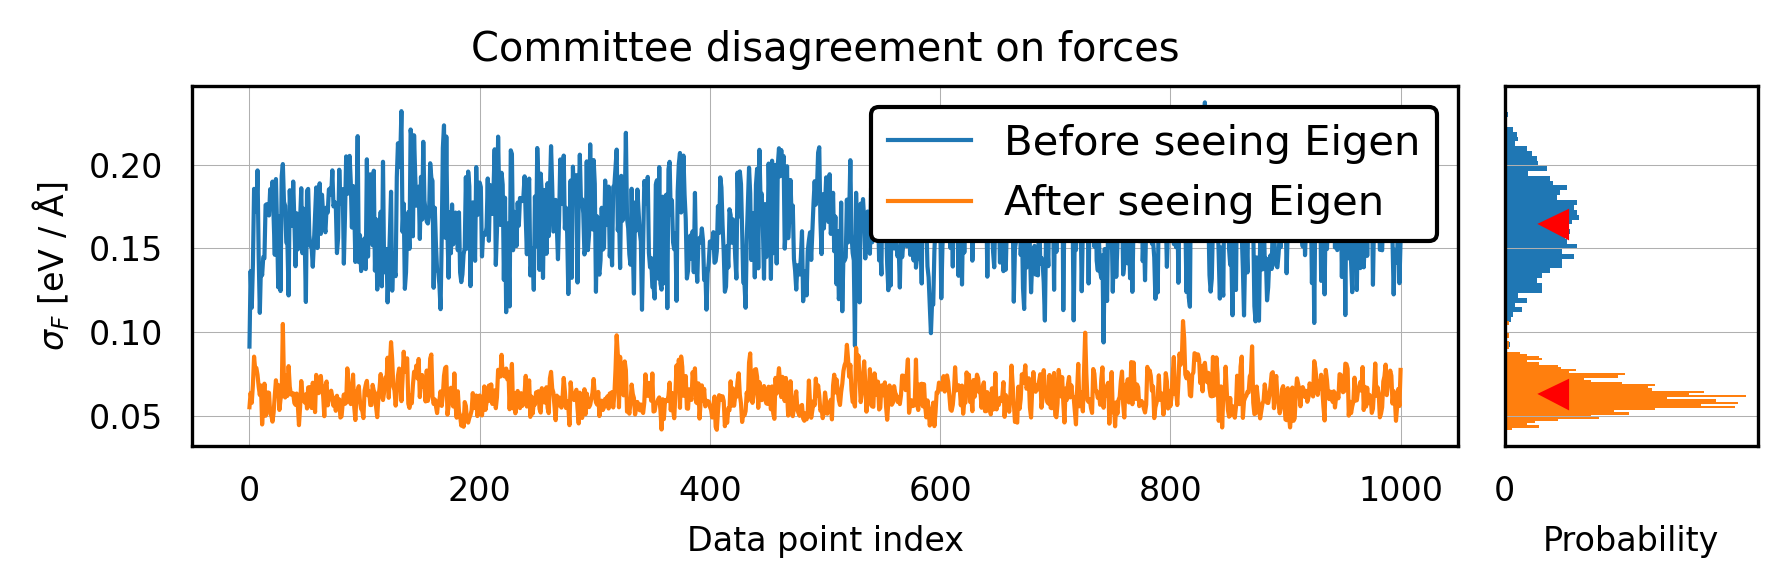

In [78]:
dt = 0.5e-3 # ps
stride = 20 # steps
time = np.arange(0, len(disagreement)) * dt * stride

fig, ax = plt.subplots(ncols=2, nrows=1, sharey=True, gridspec_kw=dict(width_ratios=[1, 0.2]))
ax[0].plot(disagreement, label='Before seeing Eigen')
ax[0].plot(disagreement_after_qbc, label='After seeing Eigen')
ax[0].set_ylabel(r'$\sigma_F$ [eV / $\mathrm{\AA}$]')
ax[0].set_xlabel('Data point index')
ax[0].grid(True)
ax[0].set_title('Committee disagreement on forces')
ax[0].legend()

ax[1].hist(disagreement, bins=50, orientation='horizontal', density=True)
ax[1].plot(10, disagreement.mean(), '<', c='r')
ax[1].hist(disagreement_after_qbc, bins=50, orientation='horizontal', density=True)
ax[1].plot(10, disagreement_after_qbc.mean(), '<', c='r')
ax[1].set_xlabel('Probability')
ax[1].set_xticks([0])

plt.tight_layout();